## Preamble

In this notebook we'll look to do the following:
* Get TFL Station location data (point data).
* Get London borough shapefiles (polygon data)
* Plot the data on a map.
    * Try various visualisation options.
* Generate 1000 locations in London at random.
* Calculate the distance between those locations and their nearest station at scale, using `kdtrees`.
* Exploring the use of voronoi diagrams to acheive a similar result.

During the project we should cover the following.
* Loading location data into `geopandas`.
* Data Visualisation.
* Spatial Joins.
* Nearest neighbour calculations with `kdtrees`.
* Creating voronoi diagrams.

## Import packages

Firstly we'll import some necessary packages in order to get started.

* `Geopandas` is a Python package which allows us access to tabular datastructures with some very helpful geospatial methods. 
* `hvplot` is visulisation package which provides a pandas-like API and `bokeh`-like plotting, it also works well with geospatial visualisations via calls to the `geoviews` package.
* `pandas` for the creation of tabular data structures.

In [1]:
import geopandas as gp
import hvplot as hv
import hvplot.pandas
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 50)

## Data Gathering

Firstly, we'll get data in London for each TFL station.

In [3]:
import geopandas as gp
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

tfl_stations = gp.read_file('data/stations.kml', driver='KML')
tfl_stations.geometry = gp.points_from_xy(tfl_stations.geometry.x, tfl_stations.geometry.y)

Now we have a table of stations in London with their names, a brief description, and their geometries.

In [4]:
tfl_stations.head()

Name                                        Description  \
0    Acton Town Station  Acton Town Station, London Underground Ltd., G...   
1       Aldgate Station  Aldgate Station, London Underground Ltd., Aldg...   
2  Aldgate East Station  Aldgate East Station, London Underground Ltd.,...   
3      Alperton Station  Alperton Station, London Underground Ltd., Eal...   
4      Amersham Station  Amersham Station, Stn Approach, Amersham, Buck...   

                    geometry  
0  POINT (-0.28025 51.50275)  
1  POINT (-0.07561 51.51427)  
2  POINT (-0.07229 51.51523)  
3  POINT (-0.29949 51.54069)  
4  POINT (-0.60748 51.67415)

Let's inspect the geometry co-ordinate reference system.

In [5]:
tfl_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Data Visualisation

Let's plot the data ont to a map, along with the `Name` of the station in the hover tool. <br>
We're using an `x` marker to differentiate them from the other points we'll be plotting.

In [6]:
tfl_stations_plot = tfl_stations.hvplot(geo=True,
                                        title='TFL Stations',
                                        marker='x',
                                        color='red',
                                        size=20,
                                        tiles='CartoLight', 
                                        hover_cols=["Name"]
                                       )
tfl_stations_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)

Now we'll get locations of some other places in London, we'll be generating 1000 points at random.

To do this, let's first get the total bounds of the polygon. <br>
We're doing so because we're only interested in random points within the total area all of the TFL stations cover. <br>
This will tell us the most `West`, `South`, `East` and `North` points respectively.

In [7]:
tfl_stations.total_bounds

array([-0.61121925, 51.40233694,  0.25108712, 51.70503045])

Now let's convert that into a polygon to get the total area covered by all the TFL stations. <br>
We can do this by using `unary_union` to bring all the points together, followed by `convex_hull` to convert the set of points to a polygon.

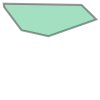

In [8]:
tfl_polygon = tfl_stations.unary_union.convex_hull
tfl_polygon

Now let's convert this Polygon to a `GeoDataFrame` by using the `GeoDataFrame` constructor.

In [9]:
area_df = gp.GeoDataFrame(
    pd.DataFrame([tfl_polygon], columns=['geometry']), 
    geometry='geometry', 
    crs=tfl_stations.crs)

We can now plot this below, I've set the transparancy to `0.1` so we can still see the tiles below.

In [10]:
area_df_plot = area_df.hvplot(geo=True, tiles='CartoLight', alpha = 0.1, c='yellow')
area_df_plot.opts(title='TFL Station footprint')

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

We can also easily plot both the stations and the convex area on one plot by using the `*` operator.

However, we need to be sure that the tiles are only defined in one of the two plots, otherwise they'll overlap and we won't be able to see the stations.

We can do this by accessing the `.Polygons` attribute of the plot we just did above, this means the `.Tiles` element of the plot is ignored.

In [11]:
(tfl_stations_plot * area_df_plot.Polygons).opts(title='TFL Stations with their total footprint')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)
   .I.I      :Polygons   [Longitude,Latitude]

Next we'll get select 1000 random points within this polygon to calculate Neighest Neighbours. <br>
The function below: `random_point_in_shp` will select a random point within a polygon.

In [12]:
from shapely.geometry import Point # cite it
def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
    return Point(x, y)

In [13]:
list_of_random_points = []
for num in range(1000):
    list_of_random_points.append(random_point_in_shp(tfl_polygon))

Now we have a list of random points within the polygon, let's turn this into a `GeoDataFrame` and plot along with the other objects.

In [14]:
random_points_in_ldn = gp.GeoDataFrame(list_of_random_points, columns=['geometry'])
random_points_in_ldn.crs = "EPSG:4326"
random_points_in_ldn.name = 'Random Points in London'

Let's have a look at some of these random points.

In [15]:
random_points_in_ldn.head()

geometry
0  POINT (-0.55315 51.65908)
1  POINT (-0.09669 51.62473)
2  POINT (-0.38707 51.49437)
3  POINT (-0.47664 51.51854)
4  POINT (-0.27406 51.45038)

## Spatial Join

So now we have the following dataframes:
* `tfl_stations`
* `area_df`
* `random_points_in_ldn`

But let's say we want to find out which area each random point is in. <br>
Fear not, we're not going to do this by hand. <br>
Instead we'll do a spatial join, where we'll take:
1. A shapefile with the boundaries of all areas in the UK
1. The random points 

We'll do a spatial join between the points and the boundaries, this will tell us which boundary each point is within.

First let's get boundary data for the UK at a Local Authority District level. <br>
Luckily, geopandas allows us to read in data from the internet directly, we simply need to supply the correct url, which we can get from the [ONS Geography](https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfe-1/geoservice) website, which is a brilliant resource for UK Geospatial data.

In [16]:
lad_url = 'https://opendata.arcgis.com/datasets/a8531598f29f44e7ad455abb6bf59c60_0.geojson'
lad_shapes = gp.read_file(lad_url, geometry='geometry')

In [17]:
lad_shapes.head()

FID  objectid    lad19cd                              lad19nm lad19nmw  \
0   51        51  E06000054                            Wiltshire            
1   52        52  E06000055                              Bedford            
2   53        53  E06000056                 Central Bedfordshire            
3   54        54  E06000057                       Northumberland            
4   55        55  E06000058  Bournemouth, Christchurch and Poole            

    bng_e   bng_n     long        lat    st_areasha     st_lengths  \
0  405209  158863 -1.92661  51.328831  3.255338e+09  402006.968204   
1  505721  256463 -0.45463  52.196281  4.764083e+08  131721.268581   
2  504615  234492 -0.47754  51.999031  7.156653e+08  232692.717695   
3  395322  600699 -2.07523  55.300369  5.077475e+09  568098.732911   
4  410815   94066 -1.84807  50.746090  1.739321e+08   90480.578175   

    Shape__Area  Shape__Length  \
0  8.320811e+09  643286.925403   
1  1.266132e+09  214772.868618   
2  1.886534e+09  377672.167042   
3  1.559751e+10  996891.573446   
4  4.341824e+08  142947.024195   

                                            geometry  
0  POLYGON ((-1.80781 51.69390, -1.80870 51.69475...  
1  POLYGON ((-0.45293 52.31798, -0.45335 52.31817...  
2  POLYGON ((-0.28166 52.18934, -0.28177 52.18935...  
3  MULTIPOLYGON (((-2.03002 55.80981, -2.03012 55...  
4  POLYGON ((-1.84148 50.80496, -1.84172 50.80508...

Let's plot these shapes to see what this looks like.

In [18]:
lad_shapes_plot = lad_shapes.hvplot(geo=True, alpha = 0.3,  crs=lad_shapes.crs.to_json(), hover_cols=['lad19nm'])

Let's look at `lad_shapes`, notice the `lad19nm` which has the name of the area and the `geometry` column which has the the Polygon objects.

In [19]:
random_points_in_ldn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
lad_shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we'll do the spatial join, just like any other join we declare the two objects we're joining together: `random_points_in_ldn` and `lad_shapes`, we then state the `how`, and we also state `op="within"` to show we want the join to occur when one point is within the boundary.

In [21]:
random_points_in_ldn_lad = gp.sjoin(random_points_in_ldn, lad_shapes, how="left", op='within')

Let's look at this new dataframe, we should see that for each random point in london that we created we see the associated area in the `lad19nm` column.

In [22]:
random_points_in_ldn_lad.head()

geometry  index_right  FID  objectid    lad19cd  \
0  POINT (-0.55315 51.65908)            7   58        58  E07000005   
1  POINT (-0.09669 51.62473)          143  294       294  E09000010   
2  POINT (-0.38707 51.49437)          333  302       302  E09000018   
3  POINT (-0.47664 51.51854)          332  301       301  E09000017   
4  POINT (-0.27406 51.45038)          342  311       311  E09000027   

                lad19nm lad19nmw   bng_e   bng_n     long        lat  \
0              Chiltern           495432  198692 -0.62112  51.678902   
1               Enfield           532829  196197 -0.08147  51.648880   
2              Hounslow           512742  174965 -0.37847  51.462429   
3            Hillingdon           508166  183120 -0.44182  51.536629   
4  Richmond upon Thames           519005  172650 -0.28914  51.440350   

     st_areasha    st_lengths   Shape__Area  Shape__Length  
0  1.963482e+08  87262.677913  5.102100e+08  140675.161791  
1  8.220019e+07  41064.649288  2.132726e+08   66130.914693  
2  5.658544e+07  57608.500059  1.456641e+08   92421.271994  
3  1.157005e+08  63887.014741  2.988013e+08  102685.824904  
4  5.876117e+07  52354.149660  1.510920e+08   83956.367244

Let's add a simple deccription column for each random point. <br>
For each row, this column will say:
* what area the random point was in
* the random point rank in that area i.e. Random point 1, 2, 3 etc.

We'll put this together with a list comprehension and an f-string.

In [23]:
random_point_number = random_points_in_ldn_lad.groupby('lad19nm')['objectid'].transform(lambda x: x.rank(method='first')).astype(str)

random_points_in_ldn_lad['random_point_desc'] = \
[f"Random point in {random_points_in_ldn_lad['lad19nm'].loc[index]}: {random_point_number.loc[index]}" 
 for index, row in random_points_in_ldn_lad.iterrows()] 

Let's sort the dataframe and have a look at it, including the `random_point_desc` column at the end.

In [24]:
random_points_in_ldn_lad = random_points_in_ldn_lad.sort_values(['lad19nm', 'random_point_desc'])
random_points_in_ldn_lad

geometry  index_right  FID  objectid    lad19cd  \
14    POINT (0.15352 51.55533)          135  286       286  E09000002   
464   POINT (0.15325 51.52890)          135  286       286  E09000002   
466   POINT (0.17617 51.56186)          135  286       286  E09000002   
502   POINT (0.11262 51.52606)          135  286       286  E09000002   
514   POINT (0.13563 51.54333)          135  286       286  E09000002   
..                         ...          ...  ...       ...        ...   
517  POINT (-0.17307 51.52740)          348  317       317  E09000033   
610  POINT (-0.11678 51.50915)          348  317       317  E09000033   
689  POINT (-0.20588 51.53053)          348  317       317  E09000033   
801  POINT (-0.12286 51.51232)          348  317       317  E09000033   
815  POINT (-0.16117 51.50211)          348  317       317  E09000033   

                  lad19nm lad19nmw   bng_e   bng_n      long        lat  \
14   Barking and Dagenham           547757  185111  0.129479  51.545551   
464  Barking and Dagenham           547757  185111  0.129479  51.545551   
466  Barking and Dagenham           547757  185111  0.129479  51.545551   
502  Barking and Dagenham           547757  185111  0.129479  51.545551   
514  Barking and Dagenham           547757  185111  0.129479  51.545551   
..                    ...      ...     ...     ...       ...        ...   
517           Westminster           528268  180870 -0.152950  51.512199   
610           Westminster           528268  180870 -0.152950  51.512199   
689           Westminster           528268  180870 -0.152950  51.512199   
801           Westminster           528268  180870 -0.152950  51.512199   
815           Westminster           528268  180870 -0.152950  51.512199   

       st_areasha    st_lengths   Shape__Area  Shape__Length  \
14   3.779933e+07  36967.152758  9.760414e+07   59416.338108   
464  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
466  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
502  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
514  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
..            ...           ...           ...            ...   
517  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
610  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
689  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
801  2.203005e+07  27156.262444  5.681777e+07   43618.645318   
815  2.203005e+07  27156.262444  5.681777e+07   43618.645318   

                            random_point_desc  
14    Random point in Barking and Dagenham: 1  
464  Random point in Barking and Dagenham: 10  
466  Random point in Barking and Dagenham: 11  
502  Random point in Barking and Dagenham: 12  
514  Random point in Barking and Dagenham: 13  
..                                        ...  
517            Random point in Westminster: 5  
610            Random point in Westminster: 6  
689            Random point in Westminster: 7  
801            Random point in Westminster: 8  
815            Random point in Westminster: 9  

[1000 rows x 16 columns]

## Section Recap

Let's plot everything we've done, to recap we now have data for the following:
* `tfl_stations` in London and Greater London. 
    * Plotted above as `tfl_stations_plot`.
* `area_df` - the convex hull of the area captured by these tfl_stations.
    * Plotted above as `area_df_plot`.
* `lad_shapes` - Shapefiles for the whole of the UK at Local Authority District level.
    * Plotted above as `lad_shapes_plot`.
* `random_points_in_ldn_lad` - 1000 random points in London we've generated, along with the area each point is in.
    * We'll plot this as `random_points_in_ldn_lad_plot` below.
    
As we're only concerned with London for this analysis, I'll filter the `lad_shapes` to only cover areas with a random point inside them, to create `ldn_lad_shapes`.

In [25]:
random_points_in_ldn_lad.head()

geometry  index_right  FID  objectid    lad19cd  \
14   POINT (0.15352 51.55533)          135  286       286  E09000002   
464  POINT (0.15325 51.52890)          135  286       286  E09000002   
466  POINT (0.17617 51.56186)          135  286       286  E09000002   
502  POINT (0.11262 51.52606)          135  286       286  E09000002   
514  POINT (0.13563 51.54333)          135  286       286  E09000002   

                  lad19nm lad19nmw   bng_e   bng_n      long        lat  \
14   Barking and Dagenham           547757  185111  0.129479  51.545551   
464  Barking and Dagenham           547757  185111  0.129479  51.545551   
466  Barking and Dagenham           547757  185111  0.129479  51.545551   
502  Barking and Dagenham           547757  185111  0.129479  51.545551   
514  Barking and Dagenham           547757  185111  0.129479  51.545551   

       st_areasha    st_lengths   Shape__Area  Shape__Length  \
14   3.779933e+07  36967.152758  9.760414e+07   59416.338108   
464  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
466  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
502  3.779933e+07  36967.152758  9.760414e+07   59416.338108   
514  3.779933e+07  36967.152758  9.760414e+07   59416.338108   

                            random_point_desc  
14    Random point in Barking and Dagenham: 1  
464  Random point in Barking and Dagenham: 10  
466  Random point in Barking and Dagenham: 11  
502  Random point in Barking and Dagenham: 12  
514  Random point in Barking and Dagenham: 13

In [26]:
ldn_lad_shapes = lad_shapes[lad_shapes['lad19cd'].isin(random_points_in_ldn_lad['lad19cd'].unique())]

In [27]:
ldn_lad_shapes = ldn_lad_shapes.to_crs(epsg=27700)

In [28]:
ldn_lad_shapes.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [29]:
ldn_lad_shapes_plot = ldn_lad_shapes.hvplot(
    crs = 'EPSG: 27700',
    alpha=0.3,
    hover_cols=['lad19nm'],
    cmap='glasbey_dark')

In [30]:
random_points_in_ldn_lad_plot = random_points_in_ldn_lad.hvplot(geo=True, s=3, hover_cols = ['random_point_desc'])

In [31]:
ldn_lad_shapes.head()

FID  objectid    lad19cd          lad19nm lad19nmw   bng_e   bng_n  \
7    58        58  E07000005         Chiltern           495432  198692   
8    59        59  E07000006      South Bucks           498198  185455   
48   99        99  E07000072    Epping Forest           548919  203758   
91  242       242  E07000240        St Albans           514580  209623   
92  243       243  E07000241  Welwyn Hatfield           525345  208467   

        long        lat    st_areasha     st_lengths   Shape__Area  \
7  -0.621120  51.678902  1.963482e+08   87262.677913  5.102100e+08   
8  -0.584840  51.559441  1.412756e+08   85473.909916  3.651027e+08   
48  0.154147  51.712791  3.389841e+08  123273.197785  8.816642e+08   
91 -0.340700  51.773560  1.612059e+08   72946.341585  4.205390e+08   
92 -0.185180  51.760872  1.295369e+08   82392.059645  3.378314e+08   

    Shape__Length                                           geometry  
7   140675.161791  POLYGON ((491750.422 208468.881, 491734.921 20...  
8   137404.373222  POLYGON ((494610.496 193736.149, 494588.696 19...  
48  198858.939454  POLYGON ((549944.460 215786.715, 549904.158 21...  
91  117815.508826  POLYGON ((515182.466 217759.781, 515182.969 21...  
92  133105.384932  POLYGON ((525183.941 219507.141, 525182.342 21...

Let's plot all the artefacts we've created thus far on a single plot. <br>
We would normally split this much information out with mutliple plots with a shared axis, but I'd like to show that plot aggregation is possible and intuitive.

In [32]:
big_plot = tfl_stations_plot * ldn_lad_shapes_plot * area_df_plot.Polygons * random_points_in_ldn_lad_plot
(big_plot).opts(
    frame_width= 900,
    frame_height= 1000,
    title_format='Various geospatial artefacts',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)


:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]   (lad19nm)
   .I.I        :Polygons   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]   (random_point_desc)

## Nearest Neighbours

You may be thinking, why did we create 1000 random points earlier, well now all is to be revealed.

Let's say we want to find the nearest tube station to everyone one of those 1000 random points. <br>
How would we do it? <br>
Remember, we have 1000 random points, and 302 stations. <br>
We could probably do a nested for loop...<br>
where, for each random point: we calculate its distance to each of the 302 stations, and then select the station with the smallest distance.

Now, whilst that might work, this approach requires `1000 x 302 == 302,000` distance calculations. <br>
It'll take some time, and how will it scale if we increase the number of points, to 10,000, or maybe a million. <br>
The answer is, not very well. 

This algorithm can be said to scale in time complexity with n<sup>2</sup>. <br>
The following section will show, that by storing our geospatial data in a binary search tree, rather than an array, we can speed up this process dramatically, such that time complexity scaled with the following relationship $O(D·N·logN)$.

Firsty, we'll change the co-ordinate reference system of our points so they are on a rectilinear geography. <br>
The algorithm we'll be using operates with euclidean distance so we need a flat plane rather than a curved plane.

This will require our data to be converted to a crs of``EPSG: 27700``, this is the rectilinear geometry for the UK.

In [33]:
tfl_stations = tfl_stations.to_crs(epsg = 27700)

In [34]:
random_points_in_ldn_lad = random_points_in_ldn_lad[['lad19nm', 'random_point_desc', 'geometry']].to_crs(epsg = 27700)

Below we'll create a function to help us calculate the nearest neighbours.

In [35]:
import numpy as np
from scipy.spatial import KDTree

In [36]:
def kdtreenearest(gdfA, gdfB):
    assert gdfA.crs.to_epsg() == gdfB.crs.to_epsg() == 27700, "Check crs."
    # Take a copy of both DataFrames
    gdfA, gdfB = gdfA.copy().reset_index(), gdfB.reset_index(drop=True)
    # Convert geometries to nested list of lists
    nA = np.array(list(zip(gdfA.geometry.x, gdfA.geometry.y)))
    nB = np.array(list(zip(gdfB.geometry.x, gdfB.geometry.y)))
    # Create kdtree object
    btree = KDTree(nB)
    # Query the tree for the nearest neigbour (k-1) with a euclidean geometry (p=2)
    dist, idx = btree.query(nA, k=1, p=2)
    # Create a list of data to concatenate, notice we ahd to reset_index the index above so the concanetation occurs on position
    # this is because when we converted our geometries to arrays, we lost row index information
    concat_list = [gdfA, 
                   gdfB.iloc[idx, :].loc[:, (gdfB.columns != 'geometry')].reset_index(drop=True),
                   pd.Series(dist, name='distance')]
    # Create the final dataframe, then add the original index of gdfA
    gdf = pd.concat(concat_list, axis=1, join='inner').set_index('index', drop=True)
    
    # Return a tuple of: the dataframe of interest, the list or raw distances, and the assocated indices of gdfB nearest neighbours
    return gdf, dist, idx

In [37]:
kdtree_results, raw_distances, idx = kdtreenearest(random_points_in_ldn_lad, tfl_stations)

That was quick!

Let's look at the results...

In [38]:
kdtree_results.head()

lad19nm                         random_point_desc  \
index                                                                   
14     Barking and Dagenham   Random point in Barking and Dagenham: 1   
464    Barking and Dagenham  Random point in Barking and Dagenham: 10   
466    Barking and Dagenham  Random point in Barking and Dagenham: 11   
502    Barking and Dagenham  Random point in Barking and Dagenham: 12   
514    Barking and Dagenham  Random point in Barking and Dagenham: 13   

                            geometry                       Name  \
index                                                             
14     POINT (549393.812 186247.328)      Dagenham East Station   
464    POINT (549461.571 183307.186)  Dagenham Heathway Station   
466    POINT (550942.143 187019.421)           Elm Park Station   
502    POINT (546652.742 182908.990)              Upney Station   
514    POINT (548192.305 184875.860)          Becontree Station   

                                             Description     distance  
index                                                                  
14     Dagenham East Station, London Underground Ltd....  1513.790856  
464    Dagenham Heathway Station, London Underground ...  1467.688345  
466    Elm Park Station, London Underground Ltd., The...  2084.795823  
502    Upney Station, London Underground Ltd., Upney ...  1566.586784  
514    Becontree Station, London Underground Ltd., Ga...   663.292867

The sample above looks to be correct, we can verify with the map we created earlier.

## Voronoi Diagrams

A Voronoi diagram is a way of partitioning a plane of points. <br>
For each point _p_ there is an associated voronoi region _R_ such that all points in R have _p_ as their closest point.

We can use voronoi diagrams to tesselate a space, this can help us answer the following question:
* For what region is Bank Station the closest possible station.

In the section above we did something similar with random points we created, with voronoi diagrams we can get straight to the region.

Let's import the necessary functions from `scipy.spatial`.

In [39]:
from scipy.spatial import Voronoi, voronoi_plot_2d

Let's convert the TFL station geometries into a nested list so `scipy` can understand them. <br>
**Remember**: These geometries must be rectilinear.

In [40]:
nA = np.array(list(zip(tfl_stations.geometry.x, tfl_stations.geometry.y))) 

This is what `tfl_stations` looks like.

In [41]:
tfl_stations.head()

Name                                        Description  \
0    Acton Town Station  Acton Town Station, London Underground Ltd., G...   
1       Aldgate Station  Aldgate Station, London Underground Ltd., Aldg...   
2  Aldgate East Station  Aldgate East Station, London Underground Ltd.,...   
3      Alperton Station  Alperton Station, London Underground Ltd., Eal...   
4      Amersham Station  Amersham Station, Stn Approach, Amersham, Buck...   

                        geometry  
0  POINT (519461.411 179603.363)  
1  POINT (533630.087 181238.190)  
2  POINT (533858.116 181351.197)  
3  POINT (518028.353 183791.884)  
4  POINT (496387.223 198182.104)

Let's construct the voronoi diagram with the `Voronoi` class.

In [42]:
tfl_vor = Voronoi(nA)

Now let's plot the regions with a simple matplotlib plot.

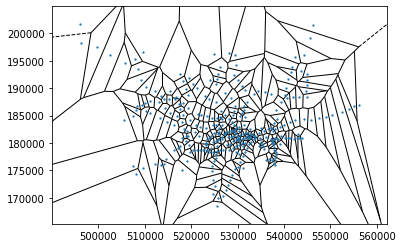

In [43]:
tfl_vor_simple_plot = voronoi_plot_2d(tfl_vor, show_vertices=False, point_size=2.5)

All looks good, but let's see if we can plot it interactively with `hvplot` just as we did earlier.

Each Voronoi object contains an attribute called `.ridge_vertices` which contains ["Indices of the Voronoi vertices forming each Voronoi ridge."](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html)

We can use these in to create a nested list (`lines`) in which each outer list contains all the lines associated with one voroni ridge.

In [44]:
import shapely
lines = \
[shapely.geometry.LineString(tfl_vor.vertices[line])for line in tfl_vor.ridge_vertices if -1 not in line]

Now we can create polygons for each voronoi region.

In [45]:
shapely_voronoi_polygons = shapely.ops.polygonize(lines)

Now we can create a `GeoDataFrame` of these voronoi polygons.

In [46]:
voronoi_polygons = gp.GeoDataFrame(shapely_voronoi_polygons, geometry = 'geometry', columns=['geometry'], crs="EPSG:27700")
voronoi_polygons.head()

geometry
0  POLYGON ((538614.396 202298.272, 556087.157 19...
1  POLYGON ((536040.026 203989.785, 538614.396 20...
2  POLYGON ((521203.423 255847.179, 523273.313 24...
3  POLYGON ((523273.313 247651.739, 533761.386 21...
4  POLYGON ((533761.386 210866.701, 536040.026 20...

Now we can do a spatial join between the stations and the voronoi polygons so we can associate each voronoi polygon with its station.

In [47]:
tfl_voronoi = gp.sjoin(tfl_stations[['Name', 'geometry']], voronoi_polygons, how='right', op='within').drop(columns=['index_left'])

Now let's create a plot for the voronoi regions.

In [48]:
tfl_voronoi_plot = tfl_voronoi.hvplot(
    geo=True,
    crs='EPSG: 27700',
    alpha=0.1
)

In [49]:
(tfl_stations_plot * tfl_voronoi_plot)\
.opts(frame_height=500,
      frame_width=800,
      title_format='TFL stations and their voronoi regions',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]

There we have it, we've plotted voronoi diagrams, explored kdtrees, looked at geopandas for geospatial transformations, and done some interactive mapping visualisations. <br>
I've left some useful links below.

### Useful Links
* [Geopandas](https://geopandas.org/)
* [hvplot - Geographic Data](https://hvplot.holoviz.org/user_guide/Geographic_Data.html)
* [shapely](https://shapely.readthedocs.io/en/latest/manual.html)